In [1]:
%matplotlib inline

import sys
import os
import numpy as np
import json
import pandas as pd
import traceback

sys.path.append(".") # add results folder as a python path 
from viz import *
from analyze import *

In [2]:
# Global variables and statistics
dataset = 'data2'
dataset_name = 'LeNet5 on MNIST-2'
num_trials =100

lookup = load_lookup_data(dataset, '../lookup')
stats = get_difficulty_stats(lookup)
#print(lookup.keys())
n_samples = 20000
total_secs =  sum(lookup.duration)
total_hours = total_secs / 3600
mean_mins = total_secs / n_samples / 60
print("Execution time - total :  {:.2f}H, mean: {:.2f}M".format(total_hours, mean_mins))
for s in stats:
    print(s)
s = stats[3]
print("Selected target threshold: {}".format(s))
print("Global optimum: {:.4f}".format(np.max(lookup['best_acc'].values)))


Execution time - total :  2113.63H, mean: 6.34M
{'difficulty': 1.0, 'error': 0.008600000000000052, 'accuracy': 0.99139999999999995}
{'difficulty': 0.5, 'error': 0.0080000009999999788, 'accuracy': 0.99199999900000002}
{'difficulty': 0.1, 'error': 0.0069000009999999889, 'accuracy': 0.99309999900000001}
{'difficulty': 0.05, 'error': 0.0067000000000000393, 'accuracy': 0.99329999999999996}
{'difficulty': 0.01, 'error': 0.0062999999999999723, 'accuracy': 0.99370000000000003}
Selected target threshold: {'difficulty': 0.05, 'error': 0.0067000000000000393, 'accuracy': 0.99329999999999996}
Global optimum: 0.9939


In [3]:
# Read sequential optimization results
results = {}
opt_secs = 86400
postfix = ".HPO_emulator({})".format(num_trials)
s_path = "./{}/T{}S/".format(dataset, opt_secs)
basic_bo = ['GP-EI', 'GP-PI', 'GP-UCB', 
              'RF-EI', 'RF-PI', 'RF-UCB' ]
rand = ['Random']
sdivs = ['S-Div', 'S-Div (hybrid)']#['S-Div', 'S-Div (log)', 'S-Div (hybrid)']
ada = ['GP-Hedge']

results['Random'] = load_json(s_path + 'RANDOM-RANDOM' + postfix + '.json')

for opt in basic_bo:
    results[opt] = load_json(s_path + opt + postfix + '.json')

results['S-Div (naive)'] = load_json(s_path + 'DIV-SEQ.pure' + postfix + '.json')
results['S-Div (log)'] = load_json(s_path + 'DIV-SEQ.log' + postfix + '.json')
results['S-Div (hybrid)'] = load_json(s_path + 'DIV-SEQ.hybrid' + postfix + '.json')
#results['R-Div (hybrid)'] = load_json(s_path + 'DIV-RANDOM.hybrid' + postfix + '.json')
results['GP-Hedge'] = load_json(s_path + 'DIV-BO-HEDGE.hedge3' + postfix + '.json')


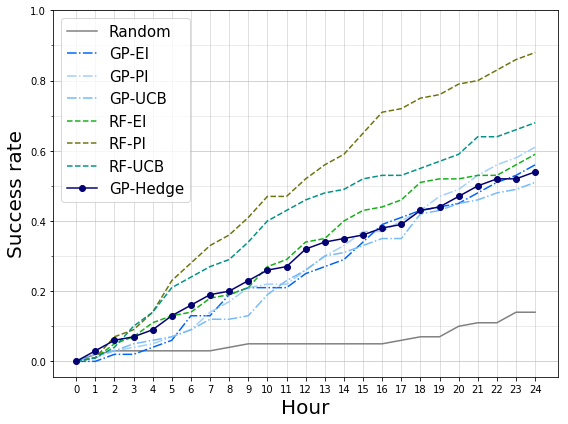

In [4]:
draw_success_rate_fig(results, s['accuracy'], 25, step_size=1,  
                                              width=8, height=6, save_name='fig-mnist2-s1', target_folder='./figs/',
                                              x_unit='Hour',  indi=rand+basic_bo,  ada=ada )

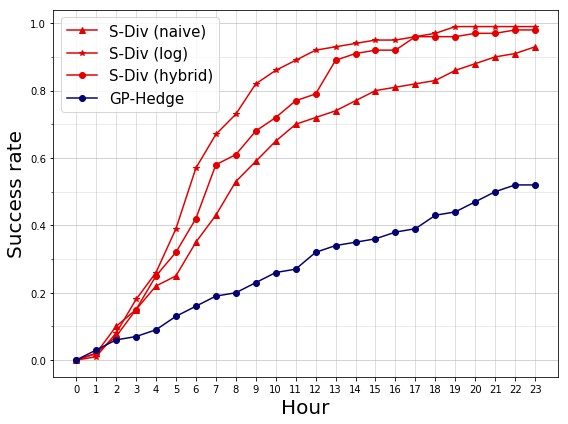

In [5]:
results['S-Div (naive)'] = load_json(s_path + 'DIV-SEQ.pure' + postfix + '.json')
results['S-Div (log)'] = load_json(s_path + 'DIV-SEQ.log' + postfix + '.json')
results['S-Div (hybrid)'] = load_json(s_path + 'DIV-SEQ.hybrid' + postfix + '.json')
#results['R-Div (hybrid)'] = load_json(s_path + 'DIV-RANDOM.hybrid' + postfix + '.json')
results['GP-Hedge'] = load_json(s_path + 'DIV-BO-HEDGE.hedge3' + postfix + '.json')

draw_success_rate_fig(results, s['accuracy'], 24, 
                                              x_unit='Hour', step_size=1,
                                               div=['S-Div (naive)', 'S-Div (log)', 'S-Div (hybrid)', 'GP-Hedge'], 
                                                 width=8, height=6,  save_name='fig-mnist2-s6', target_folder='./figs/',
                      num_runs=num_trials )

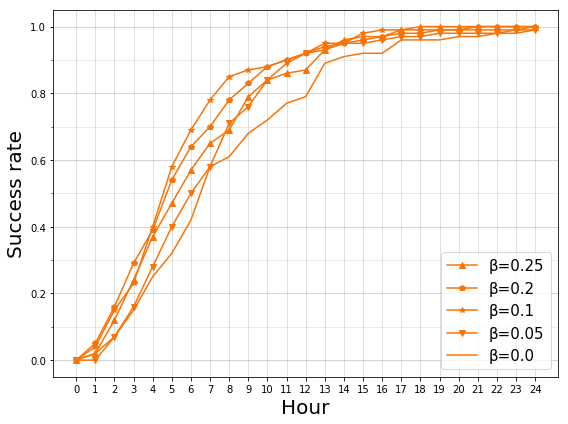

In [6]:
g_path = "./data2/G0.9933/"
threshold_etrs = {}
threshold_etrs['β=0.25'] = load_json(g_path + 'DIV-SEQ.HPO_emulator.ETR-VizTetra4_HL(100)' + '.json')
threshold_etrs['β=0.2'] = load_json(g_path + 'DIV-SEQ.HPO_emulator.ETR-VizPenta5_HL(100)' + '.json')
threshold_etrs['β=0.1'] = load_json(g_path + 'DIV-SEQ.HPO_emulator.ETR-VizDeca10_HL(100)' + '.json')
threshold_etrs['β=0.05'] = load_json(g_path + 'DIV-SEQ.HPO_emulator.ETR-VizIcosa20_HL(100)' + '.json')
threshold_etrs['β=0.0']= results['S-Div (hybrid)']


def restyle(name):
    marker = ''
    color = 'xkcd:orange'
    line_style = '-'
    if 'β=0.1' in name:
        marker = '*'  
    elif 'β=0.25' in name:
        marker = '^' 
    elif 'β=0.2' in name:
        marker = 'p'
    elif 'β=0.05' in name:
        marker = 'v'       
    return marker, color, line_style

draw_success_rate_fig(threshold_etrs, s['accuracy'], 25, 
                                              x_unit='Hour', step_size=1, 
                                               div=threshold_etrs.keys(), legend={'loc': 4}, style_format=restyle,
                                                width=8, height=6,  save_name='fig-mnist2-s7', target_folder='./figs/',
                      num_runs=num_trials )

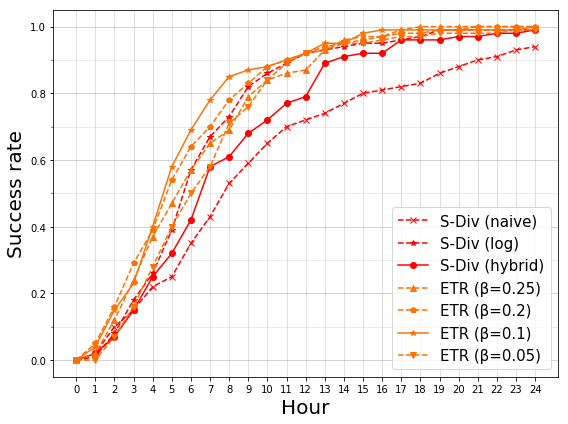

In [7]:
def restyle(name):
    marker = ''
    line_style = '--'
    color = 'red'    
    if 'ETR' in name:
        color ='xkcd:orange'
                
    if 'β=0.1' in name:
        marker = '*'  
        line_style = '-'
    elif 'β=0.25' in name:
        marker = '^' 
    elif 'β=0.2' in name:
        marker = 'p'
    elif 'β=0.05' in name:
        marker = 'v'    
    
    if '(naive)' in name:
        marker = 'x'
    elif '(log)' in name:
        marker = '*'
    elif '(hybrid)' in name:
        marker = 'o' 
        line_style = '-'
    return marker, color, line_style

thresholds = []
for key in threshold_etrs.keys():
    if key != 'β=0.0':
        results['ETR ({})'.format(key)] = threshold_etrs[key]
        thresholds.append('ETR ({})'.format(key))

draw_success_rate_fig(results, s['accuracy'], 25, 
                                              x_unit='Hour', step_size=1, 
                                               div=['S-Div (naive)', 'S-Div (log)', 'S-Div (hybrid)'] +thresholds, legend={'loc': 4}, style_format=restyle,
                                                width=8, height=6,  save_name='fig-mnist2-s8', target_folder='./figs/',
                      num_runs=num_trials )

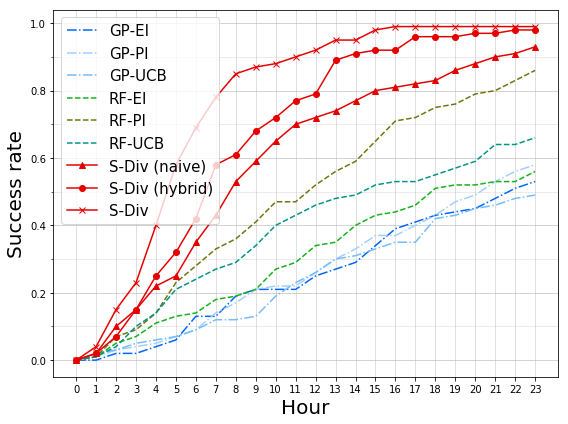

In [8]:
results[ 'S-Div']= threshold_etrs['β=0.1']
draw_success_rate_fig(results, s['accuracy'], 24, 
                                              x_unit='Hour', step_size=1,
                                               indi=basic_bo,  div=['S-Div (naive)',  'S-Div (hybrid)', 'S-Div (log)'], 
                                                 width=8, height=6,  save_name='fig-mnist2-s2', target_folder='./figs/',
                      num_runs=num_trials )

threshold_etrs = ['S-Div (hybrid)',  'S-Div + ETR(penta)', 'S-Div + ETR(deca)', ]
#results['S-Div + ETR(tetra)'] = load_json(g_path + 'DIV-SEQ.HPO_emulator.ETR-VizTetra4_HL(100)' + '.json')
results['S-Div + ETR(penta)'] = load_json(g_path + 'DIV-SEQ.hybrid.HPO_emulator.ETR-PentaTercet(100)' + '.json')
results['S-Div + ETR(deca)'] = load_json(g_path + 'DIV-SEQ.hybrid.HPO_emulator.ETR-DecaTercet(100)' + '.json')
#results['S-Div + ETR(icosa)'] = load_json(g_path + 'DIV-SEQ.HPO_emulator.ETR-VizIcosa20_HL(100)' + '.json')
draw_success_rate_fig(results, s['accuracy'], 25, 
                                              x_unit='Hour', step_size=1,
                                              div=threshold_etrs, legend={'loc': 4},
                                                width=8, height=6, # save_name='fig-mnist2-s2', target_folder='./figs/',
                      num_runs=num_trials )

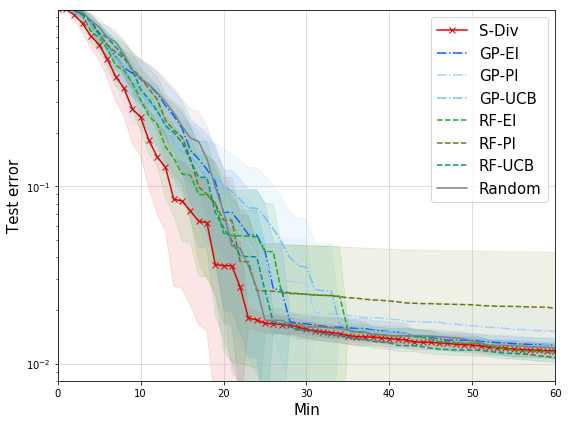

In [19]:
results['S-Div'] = load_json(s_path + 'DIV-SEQ.hybrid.HPO_emulator.ETR-VizPentaOpt(100)' + '.json')
selected =['S-Div'] + basic_bo + rand
draw_best_error_curve(results, selected, 100, x_unit="Min",
                      ylim=(.008, .99), xlim=(0, 1*60), summary=True, x_steps=10,  
                      width=8, height=6, save_name='fig-mnist2-s3', target_folder='./figs/',
#                      title="Sequential HPO of {}".format(dataset_name)
                     )

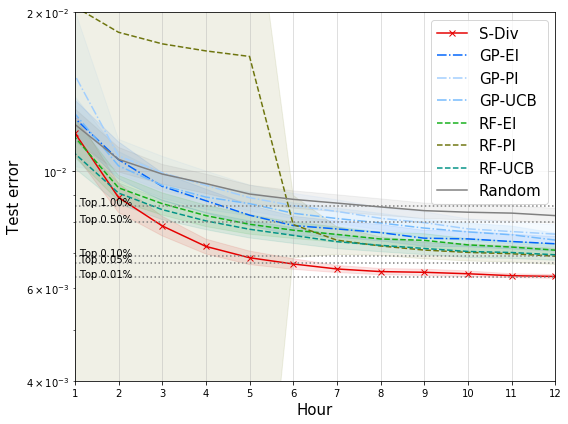

In [20]:
draw_best_error_curve(results, selected, 100, x_unit="Hour",
                      ylim=(.004, .02), xlim=(1, 12), summary=True, guidelines=stats, x_steps=1,  width=8, height=6, 
                     save_name='fig-mnist2-s4', target_folder='./figs/',
                     )

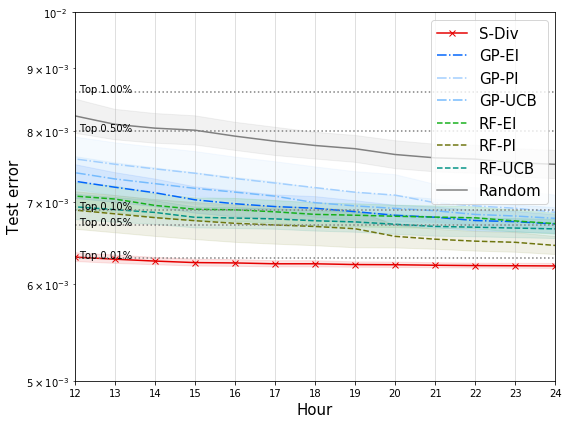

In [21]:
draw_best_error_curve(results, selected, 100, x_unit="Hour",
                      ylim=(.005, .01), xlim=(12, 24), summary=True, guidelines=stats, x_steps=1,  width=8, height=6, 
                     save_name='fig-mnist2-s5', target_folder='./figs/',
                     )

<module 'matplotlib.pyplot' from '/home/webofthink/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

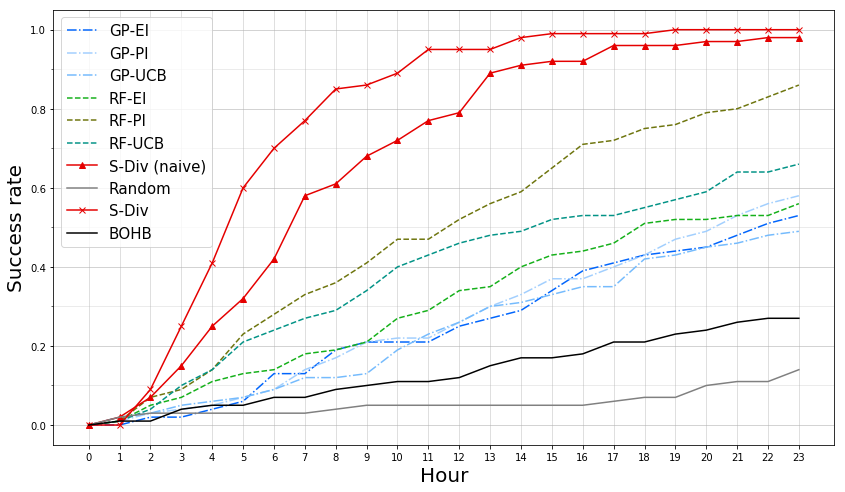

In [26]:
# BOHB performance comparision 

etr_divs = [ 'S-Div', 'BOHB'] # 'BOHB (iter100)',  'S-Div (knock)',   'S-Div (interval)',
baselines = ['S-Div (naive)', 'Random']
etr_results = {}
etr_results.update(results)
num_runs = 100
etr_results['S-Div'] = results['S-Div']
etr_results['S-Div (naive)'] = load_json(s_path + 'DIV-SEQ.hybrid.HPO_emulator(100).json')
etr_results['BOHB'] = load_json(s_path + 'BOHB.surrogate(100).json')

draw_success_rate_fig(etr_results, target_goal =s['accuracy'], x_max=24, x_unit='Hour', num_runs=num_runs,  indi=basic_bo, 
                            div=baselines + etr_divs, width=14, height=8 )

In [ ]:
print("Target goal: {}%".format(s['difficulty']))
etr_results['BOHB (100iter)'] = load_json(s_path + 'BOHB.iter100(15).json')
etr_divs.append('BOHB (100iter)')
draw_success_rate_fig(etr_results, target_goal =s['accuracy'], x_max=11, x_unit='Hour', num_runs=15, 
                            div=baselines + etr_divs, width=14, height=8 )

In [ ]:
print("Target goal: {}%".format(stats[1]['difficulty']))
draw_success_rate_fig(etr_results, target_goal =stats[1]['accuracy'], x_max=8 +1, x_unit='Hour' ,
                            div=baselines + etr_divs, width=14, height=8 )

In [ ]:
print("Target goal: {}%".format(stats[0]['difficulty']))
draw_success_rate_fig(etr_results, target_goal =s['accuracy'], x_max=8 +1, x_unit='Hour' ,
                            div=baselines + etr_divs, width=14, height=8 )

In [ ]:
sa_path = "./{}/T{}S/".format(dataset, 43200)
bm_results = {}
bm_divs = ['S-Div. (hybrid+deca)(10)', ] # 'BOHB (3-13epoch)'
#bm_results['BOHB (3-13epoch)'] = load_json(sa_path + 'BOHB.3-13epoch.(5).json')

print(s)
bm_results['S-Div. (hybrid+deca)(10)'] = load_json(sa_path + 'DIV-SEQ.ti4a.hybrid-deca.(10).json')
draw_success_rate_fig(bm_results, target_goal =s['accuracy'], x_max=12 +1, x_unit='Hour' , num_runs=10, 
                            div=bm_divs, width=14, height=8 )

In [ ]:
draw_best_error_curve(bm_results, bm_divs, 10, 
                      ylim=(.005, .8), xlim=(0, 12), summary=True, guidelines=stats, x_steps=1, x_unit='Hour', 
                      title="Sequential HPO of {}".format(dataset_name))

In [ ]:
draw_best_error_curve(bm_results, bm_divs, 10, 
                      ylim=(.005, .99), xlim=(0, 60*4), summary=True, guidelines=stats, x_steps=10, x_unit='Min', 
                      title="Sequential HPO of {}".format(dataset_name))

In [ ]:
for i in range(10):
    draw_trials_curve(bm_results, 'S-Div. (hybrid+deca)(10)', i, xlim=(0, 12), width=15, height=8, loc=1, guidelines=stats)

for i in range(5):
    draw_trials_curve(bm_results, "BOHB (3-13epoch)", i, xlim=(0, 12), ylim=(.005, 1), width=15, height=8, loc=1, guidelines=stats)

etr_results['BOHB (30iter)'] = load_json(s_path + 'BOHB.iter30(2).json')
for i in range(2):
    draw_trials_curve(etr_results, "BOHB (30iter)", i, xlim=(0, 4), width=15, height=8, loc=1, guidelines=stats)

In [ ]:
selected = ['S-Div (hybrid)', 'S-Div (penta)'] +['BOHB (surrogate)', 'BOHB (100iter)'] + ["Random"]
draw_best_error_curve(etr_results, selected, 2, 
                      ylim=(.005, .1), xlim=(0, 10), summary=True, guidelines=stats, x_steps=1, x_unit='Hour', 
                      title="Sequential HPO of {}".format(dataset_name))

In [ ]:
selected =  [ 'S-Div (median)','S-Div (penta)', 'BOHB (surrogate)', 'S-Div (hybrid)']  + ["Random"]
draw_best_error_curve(etr_results, selected, num_runs, 
                      ylim=(.005, .99), xlim=(0, 24), summary=True, guidelines=stats, x_steps=1, x_unit='Hour', 
                      title="Sequential HPO of {}".format(dataset_name))

In [ ]:

draw_best_error_curve(etr_results, selected, num_runs, 
                      ylim=(.005, .01), xlim=(0, 24), summary=True, guidelines=stats, x_steps=1, x_unit='Hour', width=16, height=8, 
                      title="Sequential HPO of {}".format(dataset_name))

In [ ]:

draw_best_error_curve(etr_results, selected, num_runs, 
                      ylim=(.005, .99), xlim=(0, 1*60), summary=True, guidelines=stats, x_steps=10, x_unit='Min', 
                      title="Sequential HPO of {}".format(dataset_name))

In [ ]:
draw_best_error_curve(etr_results, selected, num_runs, 
                      ylim=(.006, .013), xlim=(1, 12), summary=True, guidelines=stats, x_steps=1, x_unit='Hour', #width=16, height=8, 
                      title="Sequential HPO of {}".format(dataset_name), legend={"loc": 1})

In [ ]:
# Read parallel optimization results ( 6 processors)
results_6 = {}
size = 6
max_x = 2 * 6 + 1
opt_secs = 14400
postfix = "({})".format(num_trials)
p_path = "./{}/T{}S/".format(dataset, opt_secs)
results_6['Synch. GP-EI-MCMC(10)'] = load_json(p_path + 'SYNC-BATCH.M6.None.None.6GP-EI' + postfix + '.json')
results_6['GP-EI-MCMC(10)'] = load_json(p_path + 'ASYNC-BATCH.M6.None.None.6GP-EI' + postfix + '.json')
results_6['GP-EI-MCMC(1)'] = load_json(p_path + 'ASYNC-BATCH.M6.None.None.6GP-EI-no_mcmc' + postfix + '.json')
results_6['RF-EI'] = load_json(p_path + 'ASYNC-BATCH.M6.None.None.6RF-EI' + postfix + '.json')

results_6['P-Div (in-progress)'] = load_json("./data2/G0.9933/" + 'ASYNC-BATCH.M6.FO-premature.ETR-DecaTercet.hybrid-deca(100)' + '.json')
#  TODO:P-Div will be replaced with ETR applied version
results_6['P-Div'] = load_json(p_path + 'ASYNC-BATCH.M6.None.None.no_failover' + postfix + '.json')

In [ ]:
def restyle(name):
    marker = ''
    color ='black'
    line_style = '--'
    if 'GP-EI' in name:
        line_style = '-.'
        color = 'xkcd:bright blue'
    elif 'RF-EI' in name:
        color = 'xkcd:green'
    elif '-Div' in name:
        color = 'red'        
    if 'P-Div' == name:
        marker = 'x'
    elif 'P-Div (in-progress)' == name:
        marker = 'o'
    elif 'MCMC(1)' in name:
        marker = '^' 
    elif 'Synch.' in name:
        marker = '*'
    return marker, color, line_style

parallels = ['Synch. GP-EI-MCMC(10)', 'GP-EI-MCMC(10)', 'GP-EI-MCMC(1)', 'RF-EI', 'P-Div', 'P-Div (in-progress)']
p_g = []
for p in parallels:
    p_g.append({"opt": p})
    
draw_success_rate_fig(results_6, s['accuracy'], 4*60 + 1, x_unit="Min",
                                              step_size=10, style_format=restyle, 
                                               parallel=p_g, 
                                              width=8, height=6,  save_name='fig-mnist2-p1', target_folder='./figs/',
                                              num_runs=num_trials )

In [ ]:
selected = ['Synch. GP-EI-MCMC(10)', 'GP-EI-MCMC(10)', 'GP-EI-MCMC(1)', 'RF-EI', 'P-Div (in-progress)']

n_p = 6
num_trials = 100
flat_results_6 = {'Synch. GP-EI-MCMC(10)': results_6['Synch. GP-EI-MCMC(10)']}

for opt_name in [ 'GP-EI-MCMC(10)', 'GP-EI-MCMC(1)', 'RF-EI', 'P-Div (in-progress)']:
    sr_r = flatten_results(n_p, results_6, opt_name, num_trials)
    flat_results_6[opt_name] = sr_r

draw_best_error_curve(flat_results_6, selected, num_trials, x_unit='Min',
                      ylim=(.004, .5), xlim=(0, 60+1), summary=True, guidelines=stats, x_steps=5, style_format=restyle, legend={"loc": 1},
                      title="Parallel HPO of {} (6 processors)".format(dataset_name))

In [ ]:
draw_best_error_curve(flat_results_6, selected, num_trials, x_unit='Hour',
                      ylim=(.005, .02), xlim=(1, 4), summary=True, guidelines=stats, x_steps=1, style_format=restyle, 
                      title="Parallel HPO of {} (6 processors)".format(dataset_name))

In [ ]:
# For sequential HPO performance table generation
summary = []
checking_hours = [2, 4, 8, 12] # 1, 2, 6, 12
fail_summary = calc_catastrophic_failures(results, s['accuracy'], num_trials, 25)
for key in fail_summary.keys():
    r = {'optimizer':  key }
    #print("{} failure rates: {}".format(key,len( fail_summary[key])))
    for h in checking_hours:
        #print('after {} hours: {:.0f}%'.format(h, fail_summary[key][h] * 100))
        r['{:2d}h'.format(h)] = (1.0 - fail_summary[key][h]) * 100
    summary.append(r)
    
table = pd.DataFrame(summary)
table

In [ ]:
# For parallel HPO performance table generation
summary = []
checking_hours = [1, 2, 3, 4] # 1, 2, 6, 12
fail_summary = calc_catastrophic_failures(results_6, s['accuracy'], num_trials, 5)
for key in fail_summary.keys():
    r = {'optimizer':  key }
    #print("{} failure rates: {}".format(key,len( fail_summary[key])))
    for h in checking_hours:
        #print('after {} hours: {:.0f}%'.format(h, fail_summary[key][h] * 100))
        r['{:2d}h'.format(h)] = (1.0 - fail_summary[key][h]) * 100
    summary.append(r)
    
table1 = pd.DataFrame(summary)
table1

In [ ]:
# Time to success performance table generation
summary2 = []
all_results = {}
all_results.update(results)
all_results.update(results_6)
times = calc_time_to_achieve(all_results, s['accuracy'], num_trials)
for k in times.keys():
        r = times[k]
        ri = {'1_optimizer': k}
        ri['2_mean'] = r['mean']
        ri['3_sd'] = r['sd']
        summary2.append(ri)
    #print("{}: mean {:.2f}, stdev: {:.2f}".format(k, r['mean'], r['sd']))
table2 = pd.DataFrame(summary2)
table2